In [17]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [18]:
text = open('shakespeare.txt', 'r').read()
text = text.lower()
chars = sorted(list(set(text)))

In [91]:
stoi = {s: i for i,s in enumerate(chars)}
itos = {i: s for i,s in enumerate(chars)}
vsize = len(chars)
vsize

39

In [20]:
print(chars)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [90]:
data = torch.tensor([stoi[ch] for ch in text])
len(data)

1115394

In [92]:
print(''.join(itos[i.item()] for i in data[0:300]))

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you know caius marcius is chief enemy to the people.

all:
we know't, we know't.

first citizen:
let us


In [78]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        self.igate = nn.Linear(input_size + hidden_size, hidden_size) # input
        self.fgate = nn.Linear(input_size + hidden_size, hidden_size) # forget
        self.ogate = nn.Linear(input_size + hidden_size, hidden_size) # output
        self.candidate = nn.Linear(input_size + hidden_size, hidden_size) # C-tilde
        self.h2o = nn.Linear(hidden_size, output_size) # map hidden layer to outputs
        
    def forward(self, x, hc):
        hidden, cell = hc

        combine = torch.cat((x, hidden), 1)

        i = self.sigmoid(self.igate(combine))
        f = self.sigmoid(self.fgate(combine))
        o = self.sigmoid(self.ogate(combine))
        # update cell state
        cand = self.tanh(self.candidate(combine))
        cell = cell * f + cand * i
        # return output, next hidden & new cell
        hidden = self.tanh(cell) * o
        # project output to desired outsize
        out = self.h2o(hidden)
        return out.squeeze(1), (hidden, cell)
        
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size, requires_grad=False), torch.zeros(1, self.hidden_size, requires_grad=False)

In [83]:
# initialize
lstm = LSTM(vsize, 100, vsize)
optim = torch.optim.Adam(lstm.parameters(), lr=0.01)

iters = 50_000
everyN = 100
seqlen = 50
losses = []
# validation metrics
valid_cycle = 100
correct = 0
# random sampling from data
idxs = torch.randint(0, 1_000_000, size=(iters,))

for i, idx in enumerate(idxs):
    # reset optimizer and hidden/cell states
    optim.zero_grad()
    hc = lstm.init_hidden()
    
    # Get x, y; encode, prepare output tensor
    x = data[idx : idx+seqlen]
    y = data[idx+1 : idx+seqlen+1]
    x_enc = F.one_hot(x, vsize).view(seqlen, 1, vsize).float()
    out = torch.zeros((seqlen, vsize))
    
    # Forward propagation
    for j, ch in enumerate(x_enc):
        out[j], hc = lstm.forward(ch, hc)        
    
    loss = F.cross_entropy(out, y)
    
    if i % everyN == 0:
        losses.append(loss.item())
        print(f"i: {i} \tidx: {idx} \tLoss: {loss} \tOutMax: {torch.max(out)} \tArgMax: {torch.argmax(out[seqlen-1])}")
        # Max and ArgMax represent confidence and character choice
        
    # Accuracy check
    choice = torch.argmax(out[seqlen-1])
    if choice == y[seqlen-1]:
        correct += 1
        
    if i % valid_cycle == 0 and i > 0:
        print(f"i: {i} \tAccuracy: {correct / valid_cycle}")
        correct = 0
    
    # Backpropagation
    loss.backward()
    optim.step()
    

i: 0 	idx: 709870 	Loss: 3.687190294265747 	OutMax: 0.13196593523025513 	ArgMax: 24
i: 100 	idx: 32435 	Loss: 2.669894218444824 	OutMax: 4.823637008666992 	ArgMax: 27
i: 100 	Accuracy: 0.17
i: 200 	idx: 862701 	Loss: 2.3061399459838867 	OutMax: 6.896909236907959 	ArgMax: 17
i: 200 	Accuracy: 0.26
i: 300 	idx: 537053 	Loss: 2.4586663246154785 	OutMax: 6.501458644866943 	ArgMax: 1
i: 300 	Accuracy: 0.25
i: 400 	idx: 446813 	Loss: 2.3360674381256104 	OutMax: 7.105379581451416 	ArgMax: 1
i: 400 	Accuracy: 0.3
i: 500 	idx: 352949 	Loss: 2.0769729614257812 	OutMax: 7.6129536628723145 	ArgMax: 32
i: 500 	Accuracy: 0.37
i: 600 	idx: 737906 	Loss: 2.149927854537964 	OutMax: 7.740120887756348 	ArgMax: 30
i: 600 	Accuracy: 0.36
i: 700 	idx: 410595 	Loss: 2.0051004886627197 	OutMax: 7.851819038391113 	ArgMax: 32
i: 700 	Accuracy: 0.32
i: 800 	idx: 627876 	Loss: 1.8543108701705933 	OutMax: 6.908081531524658 	ArgMax: 32
i: 800 	Accuracy: 0.4
i: 900 	idx: 174218 	Loss: 2.296457529067993 	OutMax: 8.15

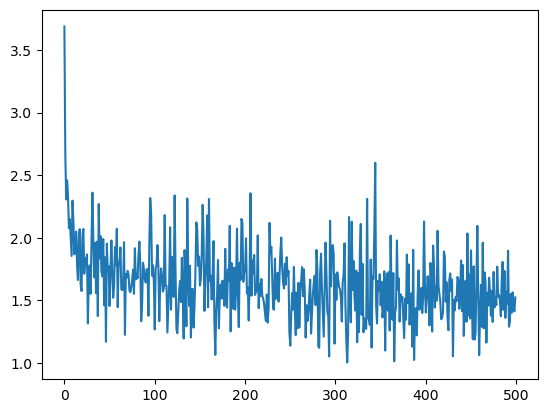

In [85]:
plt.plot(losses)
plt.show()

In [88]:
with torch.no_grad():
    char = 13
    hc = lstm.init_hidden()
    
    gen = ""
    gen += str(itos[char])
    
    for i in range(2000):
        char_enc = F.one_hot(torch.tensor([char]), vsize).view( 1 , vsize).float()
        preds, hc = lstm.forward(char_enc, hc)
        
        distr = torch.distributions.Categorical(probs=F.softmax(preds, dim=1))
        choice = distr.sample()

        char = choice
        gen += str(itos[char.item()])


In [89]:
print(gen)

ast rivelle:
i have, lecy his reft; conjint
all hide i do alt thee:
he wish the child it.

forbed:
my lords-

king edward of the amorose mind in up her harck him see your humarted somowirveful look the day his own from more.

hasturne:
hoakenly at what will to grief,
yield and king at hie off your chad many were some ,
prodixt prage.

duke of an haste:
a good can kill'd the prince's matter.

coeolitio:
sir, as holy sistorm in you by the paults;
herr an such to buckle these ever'd as that much lettem from this grople;
here your is't say samed coverit lies, i have spiping here.

shelf or my come of loving deedlio:
he been would entorm ecroster.

coriolinus:
i am so else son;
be convismastle aid of if that thise werd were my serve
all that hath goy'd and rest-lidier:
gentle supplum! this more should my lord mak is snifter'd a taitol,
that the father duke upon sorrow traitor plenots,
and like his while and soke it your iii abs had foreal!
against remest as so sentit age each he of mew ears